# Combinatorial optimization with Rydberg quantum computers

This project will explore how quantum computers can be used to solve combinatorial optimization problems.


We will focus on two approaches: one with gate-based (aka digital) quantum computers, one with analog quantum computers (aka quantum simulators).



We will go through various steps:
1. convert the optimization problem to the search of the ground state of a Hamiltonian
Design a quantum algorithm to find the ground state
2. analog algorithms
3. gate-based algorithms


This will be done with Rydberg quantum computers, as described in the following research article: http://arxiv.org/abs/1808.10816.


## Quantum programming environment

To execute the quantum programs, you will need to install the Python library called **myQLM** on your laptop. It can be installed by running the command

``pip install myqlm``

Then, you need to clone the course's repository to have access to the notebook and some helper functions:

``git clone https://github.com/tayral/phy580_2025``

It is highly advised to use the online documentation of myQLM at https://myqlm.github.io.


Should you encounter problems with the installation (which may happen for Mac users using Anaconda), you can instead use "myBinder" to run the computations:
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tayral/phy580_2025/)

... and open the ``combinatorial-optim-project.ipynb`` notebook.

In [ ]:
# optional, only for Google colab

#!pip install myqlm
#!git clone https://github.com/tayral/phy580_2026.git
#%cd phy580_2026
#!ls

## 1. The Hamiltonian of the Maximum Independent Set problem



<div class="alert alert-block alert-info">
    
- Describe the maximum independent set problem as a constrained optimization problem.
    
- How does one arrive at eq. (1)?
    
- What is the naive (classical) cost of computing the ground state of $H$?
</div>

Describe this Hamiltonian with a myQLM ``Observable`` object, called ``H_target``. Use the ``to_matrix`` method to get the matrix representation of $H_\mathrm{target}$. 

Hint: to create the Hamiltonian, you will need to first create a graph object. Use the ``networkx`` library to create such graphs. For simplicity, you can start by using "d-regular graphs".

<div class="alert alert-block alert-info">
What is its size as a function of the size of the graph?
</div>


{2, 4, 5}


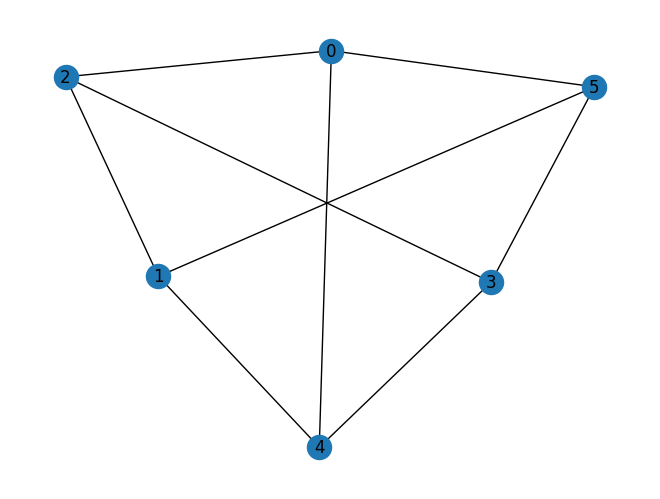

In [1]:
import networkx as nx
import random
random.seed(2534)
size = 6
d = 3 # degree
graph = nx.generators.random_regular_graph(d, size)
nx.draw(graph, with_labels=True)

approx_sol = nx.approximation.maximum_independent_set(graph)
print(approx_sol)

In [2]:
U = 1.
from qat.core import Observable, Term
nqbits = size
# H_target = sum_i -n_i + U sum_ij n_i n_j
n = [Observable(nqbits, pauli_terms=[Term(-0.5, "Z", [qb])], constant_coeff=0.5) for qb in range(nqbits)]
H_target = -sum([n[i] for i in range(nqbits)])
for i,j in graph.edges():
    H_target += U* n[i]*n[j] 
    
print(H_target)


-0.75 * I^6 +
0.25 * (ZZ|[1, 2]) +
0.25 * (ZZ|[1, 5]) +
-0.25 * (Z|[1]) +
0.25 * (ZZ|[1, 4]) +
0.25 * (ZZ|[2, 3]) +
-0.25 * (Z|[2]) +
0.25 * (ZZ|[0, 2]) +
0.25 * (ZZ|[0, 4]) +
-0.25 * (Z|[0]) +
0.25 * (ZZ|[0, 5]) +
-0.25 * (Z|[4]) +
0.25 * (ZZ|[3, 4]) +
-0.25 * (Z|[3]) +
-0.25 * (Z|[5]) +
0.25 * (ZZ|[3, 5])


### Exact solution

To know how good our solution is, we need to find the optimal solution. Given $H_\mathrm{target}$, how do you extract the exact solution? What is the cost as a function of graph size?

In [3]:
import numpy as np
mat = H_target.to_matrix()
min_energy = np.min(mat.diagonal())

sol = np.argmin(mat.diagonal())
print(f"energy= {min_energy}, sol={sol}, bin={np.binary_repr(sol, width=size)}")



energy= (-3+0j), sol=11, bin=001011


This corresponds to {2,4,5}. This is indeed a MIS for the graph (there is no bigger set).

## 2. Analog implementation for the Maximum Independent Set problem

### Part a: do the tutorial (analog_tutorial.ipynb)

It explains how to send "analog" jobs to QPUs.

### Part b: adapt it for the Rydberg situation

<div class="alert alert-block alert-info">
    
- In a Rydberg processor, what is the Hamiltonian $H_\mathrm{resource}$ that can be implemented in practice (find it in the article)?
    
- In the quantum adiabatic annealing method, what is the form $H_{QAA}$ of the time-dependent Hamiltonian that is needed? (what is $H_0$?)
    
- Are $H_\mathrm{resource}$ and $H_{QAA}$ identical?
</div>


Write a ``Schedule`` that represents $H_{QAA}$ (for now, without consideration for the difference with the available resource Hamiltonian). 


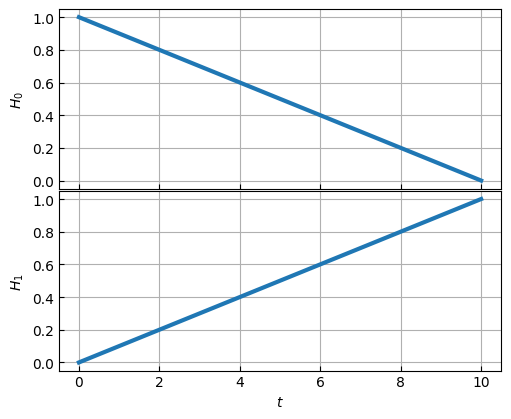

In [4]:
from qat.core import Schedule
from qat.core.variables import Variable

t = Variable("t", float)
tmax = 10.0

## define the Schedule
H0 = Observable(nqbits, pauli_terms=[Term(1.0, "X", [qb]) for qb in range(nqbits)])
schedule = Schedule(drive = [(1-t/tmax, H0), (t/tmax, H_target)], tmax=tmax)

schedule.display()

### Part c: run the algorithm

Now, use a "QPU" to run the Schedule and measure H_target at the end.

In [5]:
from basic_qutip_qpu import QutipQPU

qpu = QutipQPU() # a classical emulator of an analog QPU

# create a quantum job with a schedule and observable to be measured at the end.
job = schedule.to_job(psi_0 = "-"*nqbits, observable=H_target)

# run
res = qpu.submit(job)

/Users/thomas.ayral/Library/Python/3.9/lib/python/site-packages/qutip/core/coefficient.py:386: UserWarning: Both `cython` and `filelock` are required for compilation of string coefficents. Falling back on `eval`.
  warnings.warn(


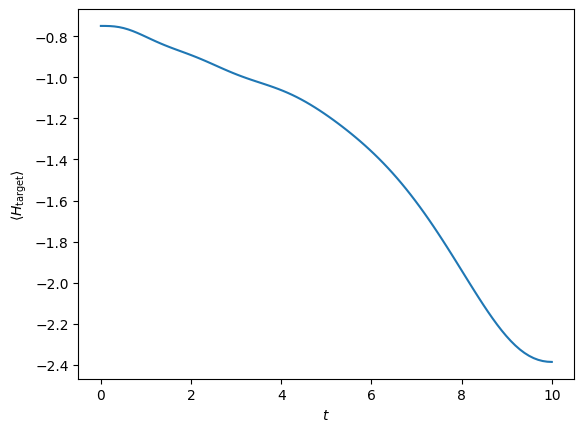

In [6]:
times = [float(t) for t in res.value_data.keys()]
vals = [res.value_data[t].re for t in res.value_data.keys()]
import matplotlib.pyplot as plt
plt.plot(times, vals)
plt.ylabel(r"$\langle H_\mathrm{target} \rangle$")
plt.xlabel(r"$t$");

#### Studying of the role of the various parameters

<div class="alert alert-block alert-info">
    
- What happens if you increase the annealing time? (this parameter is defined in the ``Schedule``object)
    
- How to read off the solution to the MIS problem? (Hint: use a job that samples the final distribution)
    
</div>

In [17]:
from qat.hardware import HardwareModel
T2 = 1.0
gamma = 1./T2
hw_model = HardwareModel(jump_operators=[np.sqrt(gamma) * Observable.sigma_z(0, 1)])

def make_simulation(tmax):
    t = Variable("t", float)
    
    ## define the Schedule
    H0 = Observable(nqbits, pauli_terms=[Term(1.0, "X", [qb]) for qb in range(nqbits)])
    schedule = Schedule(drive = [(1-t/tmax, H0), (t/tmax, H_target)], tmax=tmax)
    qpu = QutipQPU(hardware_model=hw_model) # a classical emulator of an analog QPU

    # create a quantum job with a schedule and observable to be measured at the end.
    job = schedule.to_job(psi_0 = "-"*nqbits, observable=H_target)
    
    # run
    res = qpu.submit(job)
    print(tmax, res.value)
    return res.value


tmax_list = np.linspace(1, 30, 10)
vals = [make_simulation(tmax) for tmax in tmax_list]



1.0 -0.940924010651373
4.222222222222222 -1.6265434256584679
7.444444444444445 -2.025881799781012
10.666666666666668 -2.2769781825400663
13.88888888888889 -2.395533612616358
17.11111111111111 -2.420652299770365
20.333333333333336 -2.3955546969822277
23.555555555555557 -2.3513534137944805
26.77777777777778 -2.3063172319833503
30.0 -2.2637974253906137


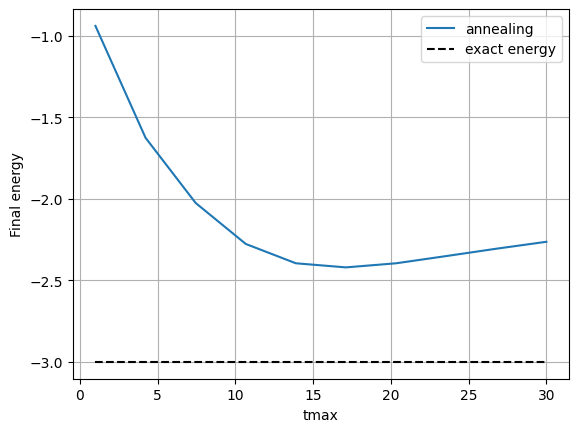

In [18]:
plt.plot(tmax_list, vals, label = "annealing")
plt.plot(tmax_list, [min_energy]*len(tmax_list), '--k', label = "exact energy")
plt.ylabel("Final energy")
plt.xlabel("tmax")
plt.grid()
plt.legend();

We see that as we increase the annealing duration, we get a final energy that is closer and closer to the energy of the exact solution.

In [ ]:
t = Variable("t", float)
tmax = 25
## define the Schedule
H0 = Observable(nqbits, pauli_terms=[Term(1.0, "X", [qb]) for qb in range(nqbits)])
schedule = Schedule(drive = [(1-t/tmax, H0), (t/tmax, H_target)], tmax=tmax)
qpu = QutipQPU() # a classical emulator of an analog QPU

# create a quantum job with a schedule (without observable in order to sample from final state).
job = schedule.to_job(psi_0 = "-"*nqbits)
    
# run
res = qpu.submit(job)
for sample in res:
    if sample.probability > 0.1:
        print(sample.state, sample.probability)

We see that two solutions {2,4,5} and {0, 1, 3} emerge.

#### More realistic simulation: with the true Hamiltonian of Rydbergs

Now, we want to actually use $H_\mathrm{resource}$. For this we can tune $\Delta(t)$ and $\Omega(t)$ (see Eq. (2) in the article) so that $H_\mathrm{resource}(t)$ looks similar to $H_{QAA}(t)$.

Remarks:

- in QA, the starting state needs to be the GS of $H_0$. In a Rydberg platform, the initial state is always $|0,0,\dots,0\rangle$. How to tune $\Delta(t=0)$ so that the ground state is indeed $|0,0,\dots,0\rangle$?

- in what types of graphs can Rydberg atoms actually implement?

#### Unit disk graph generation

In [ ]:
from itertools import product


# create a unit-disk graph at random
def generate_unit_disk_graph(size, density, r):
    """
    Generate unit disk graph points
    Args:
        size (int): number of points
        density (float): number of points per unit square
        r (float): exclusion radius (no two points are closer than this radius)

    Returns:
        list (x,y)
    """
    L = np.sqrt(size/density)
    point_list = [(random.uniform(0, L), random.uniform(0, L))]
    while len(point_list) < size:
        x = random.uniform(0, L)
        y = random.uniform(0, L) 
        #print("proposing", x, y)
        old_point_list = point_list.copy()
        within_radius = False
        for x0, y0 in old_point_list:
            d = np.sqrt((x-x0)**2 + (y-y0)**2)
            if d < r:
                within_radius = True
        if not within_radius:
            #print("adding", x,y, d)
            point_list.append((x,y))
    return point_list

def make_nx_graph(point_list):
    """ make unit disk graph out of point list"""
    graph = nx.Graph()
    node_list, edge_list = [], []
    for i, (x,y) in enumerate(point_list):
        node_list.append(i)
    for ((i, (x1,y1)), (j, (x2, y2))) in product(enumerate(point_list), repeat=2): 
        d = np.sqrt((x1-x2)**2+(y1-y2)**2)
        if d<1 and d>0:
            edge_list.append((i,j))
    
    graph.add_nodes_from(node_list)
    graph.add_edges_from(edge_list)
    return graph

random.seed(143)
size = 10
density = 2.
r = 0.3 # exclusion radius

point_list = generate_unit_disk_graph(size, density, r)
graph = make_nx_graph(point_list)

In [ ]:
nx.draw(graph, with_labels=True)

#### Annealing run

In [ ]:
# draw a random UD graph
random.seed(255)
nqbits = 5
density = 2.
r = 0.3
point_list = generate_unit_disk_graph(nqbits, density, r)
graph = make_nx_graph(point_list)

nx.draw(graph, with_labels=True)

In [ ]:
# build H_target
U = 1
n = [Observable(nqbits, pauli_terms=[Term(-0.5, "Z", [qb])], constant_coeff=0.5) for qb in range(nqbits)]
H_target = -sum([n[i] for i in range(nqbits)])
for i,j in graph.edges():
    H_target += U* n[i]*n[j] 

# do exact calculation to check
import numpy as np
mat = H_target.to_matrix()
min_energy = np.min(mat.diagonal())

sol = np.argmin(mat.diagonal())
print(f"energy= {min_energy}, sol={sol}, bin={np.binary_repr(sol, width=nqbits)}")



In [ ]:
# prepare annealing schedule
tmax = 40
t = Variable("t", float)

from qat.core.variables import sin
## define the Schedule
H_Rabi = Observable(nqbits, pauli_terms=[Term(1.0, "X", [qb]) for qb in range(nqbits)])
H_detuning = -sum([n[i] for i in range(nqbits)])
H_vdW = sum([1/((x1-x2)**2+(y1-y2)**2)**3* n[i]*n[j]
             for ((i,(x1,y1)), (j, (x2, y2))) in product(enumerate(point_list), repeat=2) if i != j]) 

schedule = Schedule(drive = [(sin(t*np.pi/tmax)**2, H_Rabi),
                             (4*(t/tmax -1/2) , H_detuning),
                             (1, H_vdW)
                            ],
                    tmax=tmax)

schedule.display()

In [ ]:
qpu = QutipQPU(n_steps=1000) # a classical emulator of an analog QPU

# create a quantum job with a schedule and observable to be measured at the end.
job = schedule.to_job(observable=H_target)
    
# run
res = qpu.submit(job)
print(tmax, res.value)

It makes sense!

In [ ]:
times = [float(t) for t in res.value_data.keys()]
vals = [res.value_data[t].re for t in res.value_data.keys()]
import matplotlib.pyplot as plt
plt.plot(times, vals)
plt.ylabel(r"$\langle H_\mathrm{target} \rangle$")
plt.xlabel(r"$t$");

In [ ]:
job = schedule.to_job() # sample mode 
    
# run
res = qpu.submit(job)
for sample in res:
    if sample.probability > 0.1:
        print(sample.state, sample.probability)

<div class="alert alert-block alert-info">
What do you observe?
</div>

Solutions {0, 2} and {0, 1} which are also admissible solutions.

### Going beyond unit-disk graphs


<div class="alert alert-block alert-info">

- Is it possible to handle graphs which are not unit-disk graphs? How so? What additional assumptions do you need on the hardware?
    
</div>

## 3. Gate-based implementation for the MIS problem


We now assume we can use the Rydberg atom platform as a digital (gate-based) platform.

<div class="alert alert-block alert-info">

- Under which conditions can one use a Rydberg platform as a gate-based quantum computer?

</div>


### Prerequisite

Do the myQLM tutorial on digital (gate-based) computation: ``digital_tutorial.ipynb``.

### QAOA algorithm


<div class="alert alert-block alert-info">
    
- Describe the QAOA algorithm for a general combinatorial optimization problem (look at appendix I.B.1 of the article)
    
- What is the role of parameter $p$?
    
- In your case, what energy are you tring to maximize?
    
- What is the form of the ansatz circuit?
    
</div>

We are now going to implement QAOA with myQLM.


#### Ansatz circuit

Using the same graph you used before (e.g the d-regular graph above), construct a parametric quantum circuit (see the documentation here: https://myqlm.github.io/02_user_guide/01_write/01_digital_circuit/02_variational.html)

In [ ]:
from qat.lang.AQASM import Program, H, RY, CNOT

size = 10
d = 3 # degree
graph = nx.generators.random_regular_graph(d, size)

prog = Program()
reg = prog.qalloc(size)
thetas = [prog.new_var(float, '\\theta_%s'%i) for i in range(size)]
for ind in range(size):
    RY(thetas[ind])(reg[ind])
for ind in range(size-1):
    CNOT(reg[ind], reg[ind+1])

var_circ = prog.to_circ()

var_circ.display()

### Optimization

In Qaptiva, the optimization is done with "plugins". They essentially perform the optimization of the parameters for a given cost function.

In [ ]:
# build H_target
nqbits = size
U = 1
n = [Observable(nqbits, pauli_terms=[Term(-0.5, "Z", [qb])], constant_coeff=0.5) for qb in range(nqbits)]
H_target = -sum([n[i] for i in range(nqbits)])
for i,j in graph.edges():
    H_target += U* n[i]*n[j] 


#### solution 
from qat.qpus import get_default_qpu
from qat.plugins import ScipyMinimizePlugin

qpu = get_default_qpu() # a classical emulator of gate-based QPUs.
plugin = ScipyMinimizePlugin(method="COBYLA",
                            tol=1e-5, 
                            options={"maxiter": 200})
stack = plugin | qpu

job = var_circ.to_job(observable = H_target) 
result = stack.submit(job)
print("Final energy:", result.value)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(eval(result.meta_data["optimization_trace"]))
plt.xlabel("steps")
plt.ylabel("energy")
plt.show()

### Reading off the solution

The QAOA procedure yields a value of the optimized parameters, contained in the ``result`` variable (see ``result.meta_data`` field). We now want to recover the state corresponding to these optimized parameters, so that we can read the solution to the UDMIS problem.

For this, we need to evaluate our parameterized quantum circuit ``var_circ`` on the optimized values of the variables.
This can be achieved like this: if a circuit has a single variable ``toto``, then replacing occurrences of ``toto`` by its value (say 5) can be done via:

```python
dic = {"toto" : 5.0}
circ = var_circ(**dic)
```

In [ ]:
# retrieving the parameters and putting them in var_circ

circ = var_circ(**eval(result.meta_data["parameter_map"]))

# executing the circ on the QPU in "SAMPLE" mode (no observables)

res = qpu.submit(circ.to_job())
for sample in res:
    if (sample.probability > 0.01):
        print(sample.state, sample.probability)

Let us check that the solutions found by QAOA are indeed close to the exact solution:

In [ ]:
mat = H_target.to_matrix()
min_energy = np.min(mat.diagonal())

sol = np.argmin(mat.diagonal())
print(f"energy= {min_energy}, sol={sol}, bin={np.binary_repr(sol, width=size)}")

## 4. Conclusions

<div class="alert alert-block alert-info">

- What are the respective advantages and drawbacks of QA (analog) and QAOA (gate-based)?
    
- Compared to the exact solution, how do quantum algorithms fare?

</div>

## 5. Going further

- Here, we have used for simplicity d-regular graphs. Repeat the experiments on actual unit-disk graphs (for this, think how to generate random unit-disk graphs

- What do you expect the role of decoherence to be in both cases?